# Lossless JPEG Experimentation

Question: how effective is JPEG-LS at compressing our 1 second exposures? 

This notebook compares the effectiveness of JPEG-LS compared to JPEG and JPEG-2000 for several simple parameterizations.
The relevant metric here is just the ratio of the file size between the JPEG-LS files compared to other formats.

In [330]:
import pathlib
import tempfile

import numpy as np
import matplotlib.pyplot as plt
from astropy.visualization import ImageNormalize, LogStretch, AsymmetricPercentileInterval
import astropy.units as u

import PIL
import pillow_jpls

from overlappy.util import color_lat_lon_axes
from mocksipipeline.util import stack_components

In [331]:
def compare_jpeg_ls_compression(array, compare_format='JPEG2000', mode='I;16'):
    pil_image = PIL.Image.fromarray(array.astype(np.uint16)).convert(mode=mode)
    with tempfile.TemporaryDirectory() as tmpdir:
        tmpdir_p = pathlib.Path(tmpdir)
        jpls_path = tmpdir_p / 'image.jls'
        jp_path = tmpdir_p / 'image.jpg'
        pil_image.save(jpls_path, format='JPEG-LS')
        pil_image.save(jp_path, format=compare_format)
        ratio = jp_path.stat().st_size / jpls_path.stat().st_size
    return ratio

In [332]:
data_dir = pathlib.Path('data/')

In [333]:
files = data_dir.glob('overlappogram-ar-photons-order=*.fits')

In [334]:
overlappogram = stack_components(sorted(files), wcs_index=2)

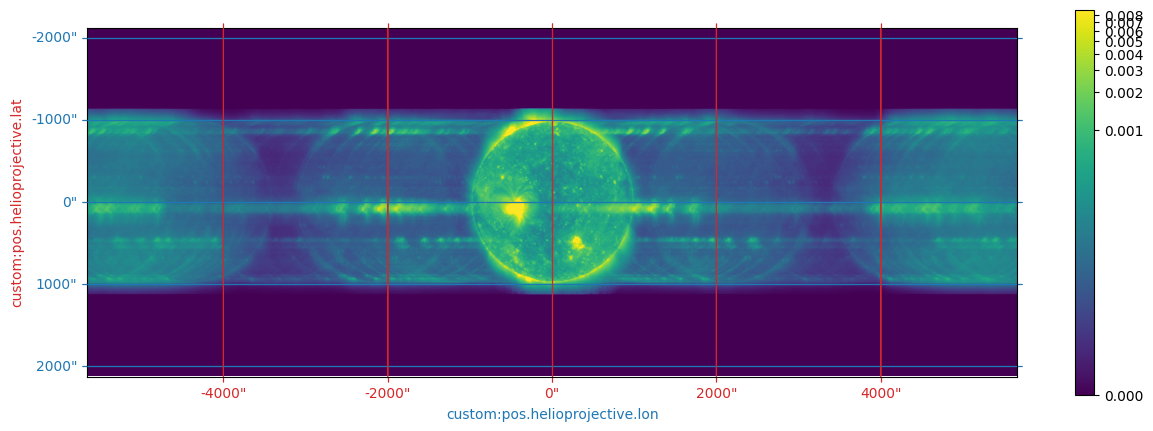

In [335]:
fig = plt.figure(figsize=(15,5))
vmin,vmax = AsymmetricPercentileInterval(1,99.9).get_limits(overlappogram[0].data)
#vmin,vmax = None, None
norm = ImageNormalize(vmin=vmin, vmax=vmax, stretch=LogStretch())
ax = fig.add_subplot(projection=overlappogram[0].wcs)
overlappogram[0].plot(
    axes=ax,
    norm=norm,
    data_unit='photon / (pix s)',
    cmap='viridis',
)
color_lat_lon_axes(ax)
plt.colorbar()

## Everything is 1

In [336]:
overlappogram_ones = np.ones(overlappogram.data[0].shape)

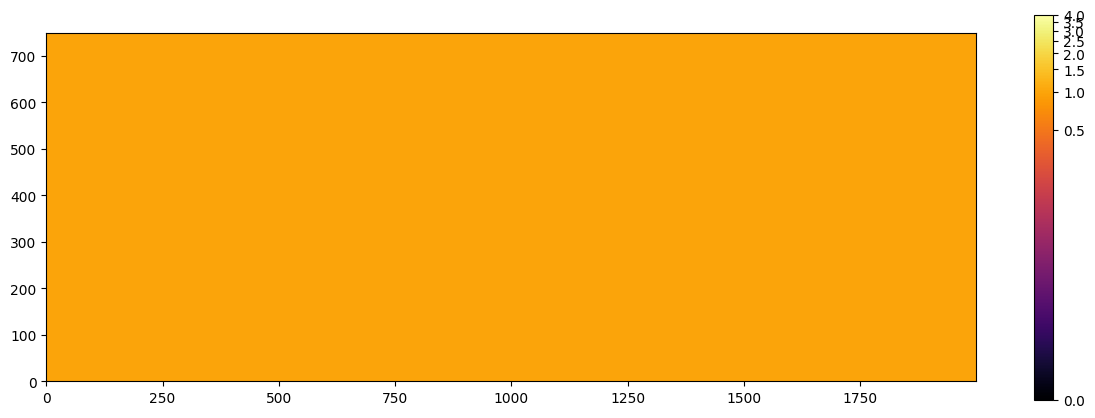

In [337]:
plt.figure(figsize=(15,5))
vmin, vmax = AsymmetricPercentileInterval(0,100).get_limits(overlappogram_random)
plt.imshow(overlappogram_ones,
           origin='lower', norm=ImageNormalize(vmin=vmin, vmax=vmax, stretch=LogStretch()), interpolation='none', cmap='inferno')
plt.colorbar()

In [338]:
compare_jpeg_ls_compression(overlappogram_ones, compare_format='JPEG', mode='L')

40.534988713318285

In [339]:
compare_jpeg_ls_compression(overlappogram_ones, compare_format='JPEG2000', mode='I;16')

0.43566176470588236

## Everything is 0

In [340]:
overlappogram_zeros = np.zeros(overlappogram.data[0].shape)

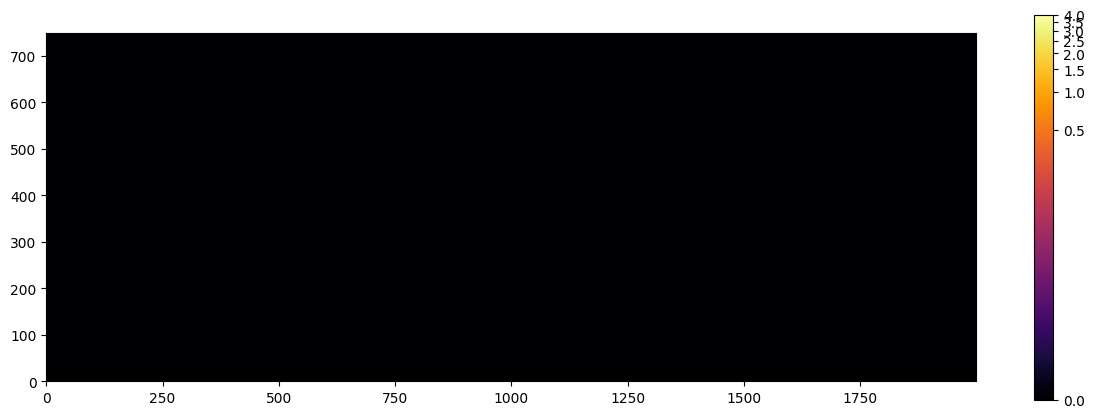

In [341]:
plt.figure(figsize=(15,5))
vmin, vmax = AsymmetricPercentileInterval(0,100).get_limits(overlappogram_random)
plt.imshow(overlappogram_zeros,
           origin='lower', norm=ImageNormalize(vmin=vmin, vmax=vmax, stretch=LogStretch()), interpolation='none', cmap='inferno')
plt.colorbar()

In [342]:
compare_jpeg_ls_compression(overlappogram_zeros, compare_format='JPEG', mode='L')

102.61142857142858

In [343]:
compare_jpeg_ls_compression(overlappogram_zeros, compare_format='JPEG2000', mode='I;16')

1.2526315789473683

## Random Counts

Random distribution of counts over the detector

In [344]:
overlappogram_random = np.random.randint(0, high=5, size=overlappogram.data[0].shape, dtype=np.uint16)

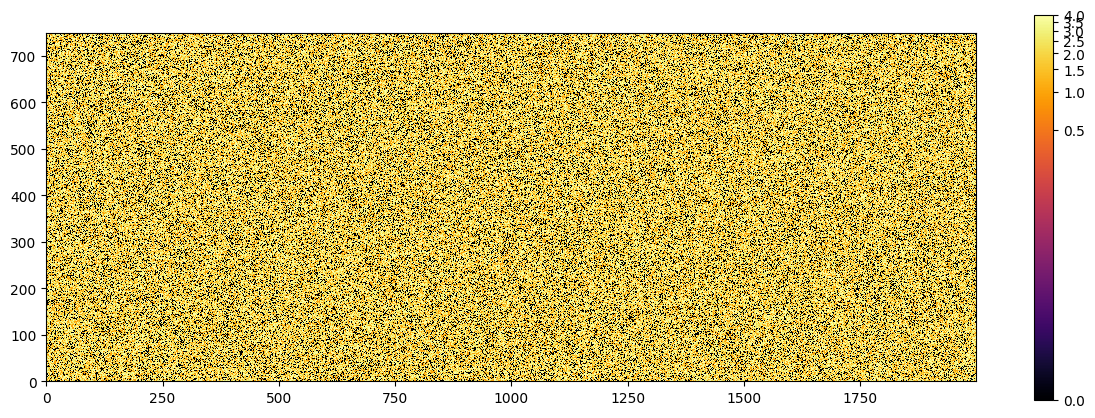

In [345]:
plt.figure(figsize=(15,5))
vmin, vmax = AsymmetricPercentileInterval(0,100).get_limits(overlappogram_random)
plt.imshow(overlappogram_random,
           origin='lower', norm=ImageNormalize(vmin=vmin, vmax=vmax, stretch=LogStretch()), interpolation='none', cmap='inferno')
plt.colorbar()

In [346]:
compare_jpeg_ls_compression(overlappogram_random, compare_format='JPEG', mode='L')

0.04321031209613928

In [347]:
compare_jpeg_ls_compression(overlappogram_random, compare_format='JPEG2000', mode='I;16')

0.9794358427904818

## Thresholding non-zero values

This just makes everything over some threshold value 1 and everything else 0

In [348]:
overlappogram_bool = (overlappogram.data[0] > 0.001).astype(np.uint16)

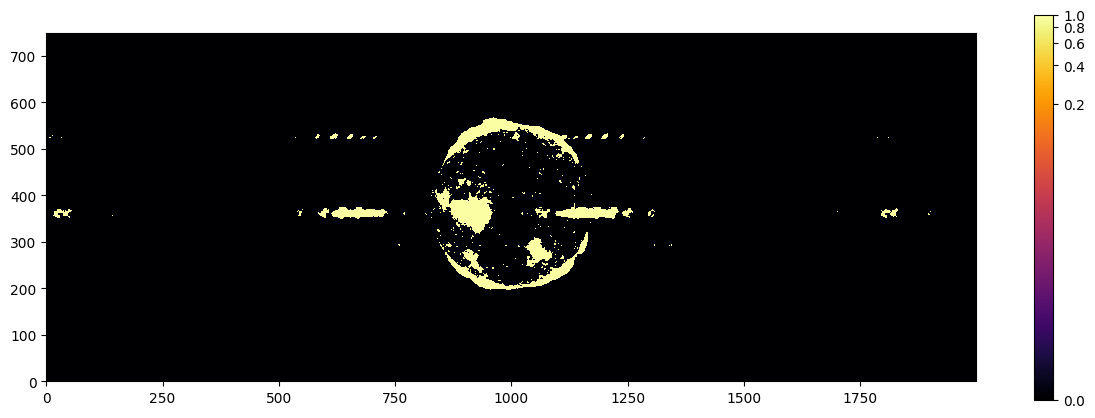

In [349]:
plt.figure(figsize=(15,5))
vmin, vmax = AsymmetricPercentileInterval(0,100).get_limits(overlappogram_bool)
plt.imshow(overlappogram_bool,
           origin='lower', norm=ImageNormalize(vmin=vmin, vmax=vmax, stretch=LogStretch()), interpolation='none', cmap='inferno')
plt.colorbar()

In [350]:
compare_jpeg_ls_compression(overlappogram_bool, compare_format='JPEG', mode='L')

3.4132778513334596

In [351]:
compare_jpeg_ls_compression(overlappogram_bool, compare_format='JPEG2000', mode='I;16')

1.1920772303595206

## Sampling from a Poisson Distribution 

Use the simulated image create a Poisson distribution for each pixel.

In [352]:
dt = 1 * u.s

In [353]:
probability_rate = overlappogram[0].data * overlappogram.unit * u.pix

In [354]:
counts = np.random.poisson(lam=(probability_rate*dt).to_value('photon'))

In [355]:
counts

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

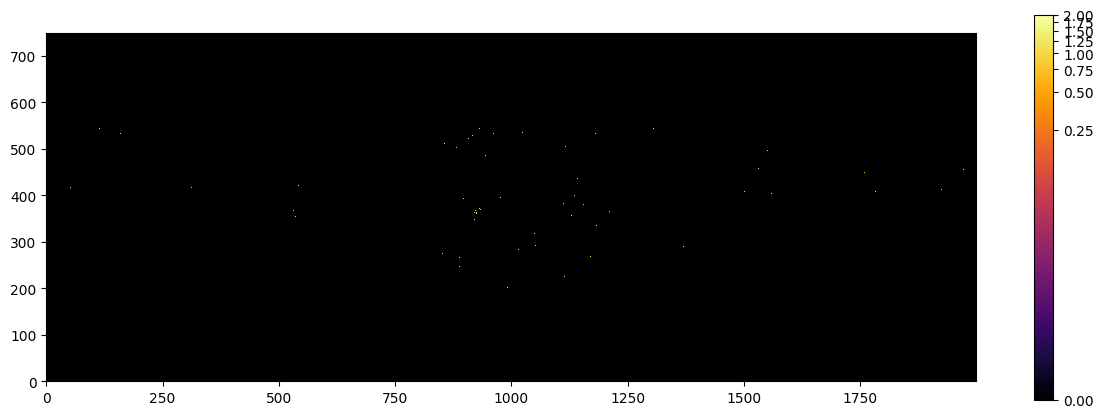

In [356]:
plt.figure(figsize=(15,5))
vmin, vmax = AsymmetricPercentileInterval(0,100).get_limits(counts)
plt.imshow(counts,
           origin='lower', norm=ImageNormalize(vmin=vmin, vmax=vmax, stretch=LogStretch()), interpolation='none', cmap='inferno')
plt.colorbar()

In [357]:
compare_jpeg_ls_compression(counts, compare_format='JPEG', mode='L')

31.121317157712305

In [358]:
compare_jpeg_ls_compression(counts, compare_format='JPEG2000', mode='I;16')

1.2010178117048347

## Scaling Up the Overlappogram Image

In [363]:
scaling_factor = 1 / overlappogram.data[0][np.nonzero(overlappogram.data[0])].min()

In [366]:
overlappogram_scaled = (overlappogram.data[0] * scaling_factor).astype(np.uint16)

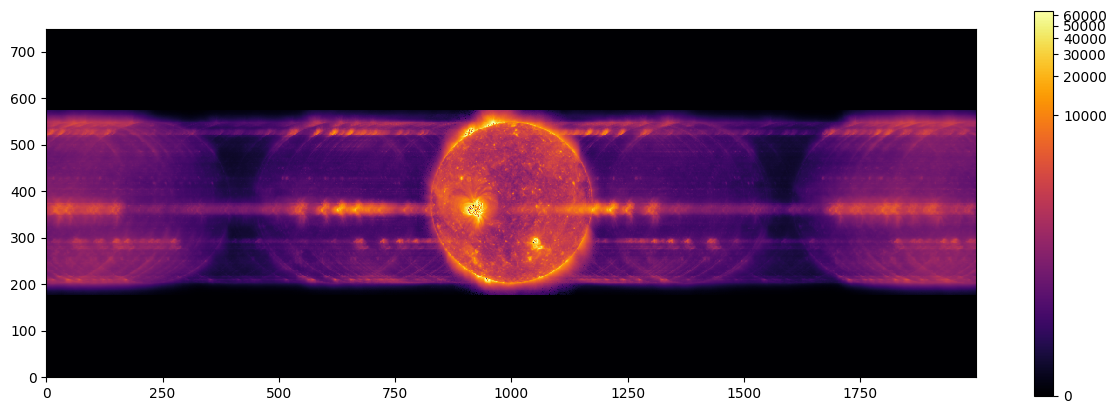

In [367]:
plt.figure(figsize=(15,5))
vmin, vmax = AsymmetricPercentileInterval(0,100).get_limits(overlappogram_scaled)
plt.imshow(overlappogram_scaled,
           origin='lower', norm=ImageNormalize(vmin=vmin, vmax=vmax, stretch=LogStretch()), interpolation='none', cmap='inferno')
plt.colorbar()

In [368]:
compare_jpeg_ls_compression(overlappogram_scaled, compare_format='JPEG', mode='L')

0.42398613471627894

In [369]:
compare_jpeg_ls_compression(overlappogram_scaled, compare_format='JPEG2000', mode='I;16')

1.0092772115200903

## Conclusions

- JPEG2000 and JPEG-LS provide similar compression in nearly all cases
- JPEG-LS provides marginally better performance (factor of $\approx1.2$) than JPEG2000 for Poisson sampling case
- The noiser the image, the worse JPEG-LS does compared to normal JPEG--see uniform distribution case above
- The more areas of continuous tone the better the performance
- More zeros perform better than more non-zeros
- JPEG-LS provides a factor of $\approx30$ better compression than JPEG for most realistic case of Poisson sampling
- The more photons we have, the worse JPEG-LS will do